In [1]:
import sys,os,math,string,time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from pyzillow.pyzillow import ZillowWrapper, GetDeepSearchResults
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import ensemble, tree, linear_model
import seaborn as sns
import scipy.stats as st
import missingno as msno
import pickle
pd.options.display.max_rows = 200

%matplotlib inline 

In [2]:
df = pd.read_csv("downsized_6.csv")
df = df.drop(columns=["Unnamed: 0"],axis=1)

In [3]:
df.columns

Index(['key', 'PID', 'ST_NUM', 'ST_NAME', 'ST_NAME_SUF', 'ZIPCODE', 'PTYPE',
       'LU', 'OWN_OCC', 'AV_BLDG', 'AV_TOTAL', 'GROSS_TAX', 'LAND_SF',
       'YR_BUILT', 'YR_REMOD', 'GROSS_AREA', 'LIVING_AREA', 'NUM_FLOORS',
       'R_BLDG_STYL', 'R_ROOF_TYP', 'R_EXT_FIN', 'R_TOTAL_RMS', 'R_BDRMS',
       'R_FULL_BTH', 'R_HALF_BTH', 'R_BTH_STYLE', 'R_KITCH', 'R_KITCH_STYLE',
       'R_HEAT_TYP', 'R_AC', 'R_FPLACE', 'R_EXT_CND', 'R_OVRALL_CND',
       'R_INT_CND', 'R_INT_FIN', 'R_VIEW', 'FULLADD', 'R_TOTAL_BTH',
       'MARKET_VALUE', 'DIFF_MV', 'DIFF_TAX', 'Lattitude', 'Longitude',
       'LatLon', 'DIS0', 'DIS1', 'DIS2', 'DIS3', 'DIS4', 'DIS5'],
      dtype='object')

In [4]:
df = df.drop(columns=["DIFF_TAX","DIFF_MV","Lattitude","Longitude","LatLon"],axis=1)

In [5]:
df["DIS0"] = 1.0/np.abs(df["DIS0"]); # 1/distance to nearest metro - larger the distance - smaller the feature
df["MARKET_VALUE"] = np.log(df["MARKET_VALUE"])
df["GROSS_AREA"] = np.log(df["GROSS_AREA"])
df["LIVING_AREA"] = np.log(df["LIVING_AREA"])
df["YR_REMOD"] = df["YR_REMOD"].fillna(value=0.0); 
df['OWN_OCC'] = df['OWN_OCC'].map({'Y': 1, 'N': 0})
df["key"] = pd.to_numeric(df["key"], errors='ignore')
df = df.dropna(); 
print(len(df))

28432


In [6]:
for feat in df.columns: 
    temper = df[df[feat].isna()]
    if(len(temper)>0): 
        print(feat, len(temper))

# --- additional feature engineering! ---

## (1) Avg zipcode Market-value per year. 


In [7]:
Zips = pd.unique(df["ZIPCODE"])
Years = pd.unique(df["key"])
df2 = pd.DataFrame(columns=df.columns)

for yr in Years:
    temper = df[df["key"]==yr];
    for zv in Zips:
        temper2 = temper[temper["ZIPCODE"]==zv];
        temper2["ZIPYR_TAX"] = temper2["AV_TOTAL"].mean()
        df2 = df2.append(temper2)
df2["ZIPYR_TAX"] = np.log(df2["ZIPYR_TAX"])

df = df2.copy(deep=True); 
del df2
df2 = pd.DataFrame(columns=df.columns)
for zv in Zips:
    temper2 = df[df["ZIPCODE"]==zv];
    temper2["ZIP_MV"] = temper2["MARKET_VALUE"].mean()
    df2 = df2.append(temper2)
    
print(len(df2))

/home/npatel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/npatel/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/home/npatel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

28432


In [8]:
# Lets print out to prevent re-running 
df2.to_csv("downsized_7.csv",index=False)

In [9]:
myfeat = ['key', 'PTYPE',
       'LU', 'OWN_OCC', 'LAND_SF', 'YR_BUILT', 'YR_REMOD', 'GROSS_AREA', 'NUM_FLOORS',
       'R_BLDG_STYL', 'R_ROOF_TYP', 'R_EXT_FIN', 'R_TOTAL_RMS', 'R_BDRMS',
       'R_FULL_BTH', 'R_HALF_BTH', 'R_BTH_STYLE', 'R_KITCH', 'R_KITCH_STYLE',
       'R_HEAT_TYP', 'R_AC', 'R_FPLACE', 'R_EXT_CND',
       'R_INT_CND', 'R_INT_FIN', 'R_VIEW', 'R_TOTAL_BTH','MARKET_VALUE', "ZIPYR_TAX",
        'DIS0']
data = df2[myfeat]

In [10]:
data["key"] = pd.to_numeric(data["key"], errors='ignore')

/home/npatel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
data = pd.get_dummies(data)

In [12]:
all_features = data.columns
index = np.argwhere(all_features=="MARKET_VALUE")
all_features = np.delete(all_features, index)
target_feature = "MARKET_VALUE"

In [13]:
data.columns

Index(['key', 'PTYPE', 'LAND_SF', 'YR_BUILT', 'YR_REMOD', 'GROSS_AREA',
       'NUM_FLOORS', 'R_TOTAL_RMS', 'R_BDRMS', 'R_FULL_BTH', 'R_HALF_BTH',
       'R_KITCH', 'R_FPLACE', 'R_TOTAL_BTH', 'MARKET_VALUE', 'ZIPYR_TAX',
       'DIS0', 'LU_R1', 'LU_R2', 'LU_R3', 'OWN_OCC_0', 'OWN_OCC_1',
       'R_BLDG_STYL_BW', 'R_BLDG_STYL_CL', 'R_BLDG_STYL_CN', 'R_BLDG_STYL_CP',
       'R_BLDG_STYL_CV', 'R_BLDG_STYL_DK', 'R_BLDG_STYL_DX', 'R_BLDG_STYL_OT',
       'R_BLDG_STYL_RE', 'R_BLDG_STYL_RM', 'R_BLDG_STYL_RN', 'R_BLDG_STYL_RR',
       'R_BLDG_STYL_SD', 'R_BLDG_STYL_SL', 'R_BLDG_STYL_TD', 'R_BLDG_STYL_TF',
       'R_BLDG_STYL_TL', 'R_BLDG_STYL_VT', 'R_ROOF_TYP_F', 'R_ROOF_TYP_G',
       'R_ROOF_TYP_H', 'R_ROOF_TYP_L', 'R_ROOF_TYP_M', 'R_ROOF_TYP_S',
       'R_EXT_FIN_A', 'R_EXT_FIN_B', 'R_EXT_FIN_C', 'R_EXT_FIN_F',
       'R_EXT_FIN_G', 'R_EXT_FIN_M', 'R_EXT_FIN_O', 'R_EXT_FIN_P',
       'R_EXT_FIN_S', 'R_EXT_FIN_U', 'R_EXT_FIN_V', 'R_EXT_FIN_W',
       'R_BTH_STYLE_L', 'R_BTH_STYLE_M', 'R_BTH_

In [14]:
for feat in data.columns: 
    temper = data[data[feat].isna()]
    if(len(temper)>0): 
        print(feat, len(temper))

(95, 95)


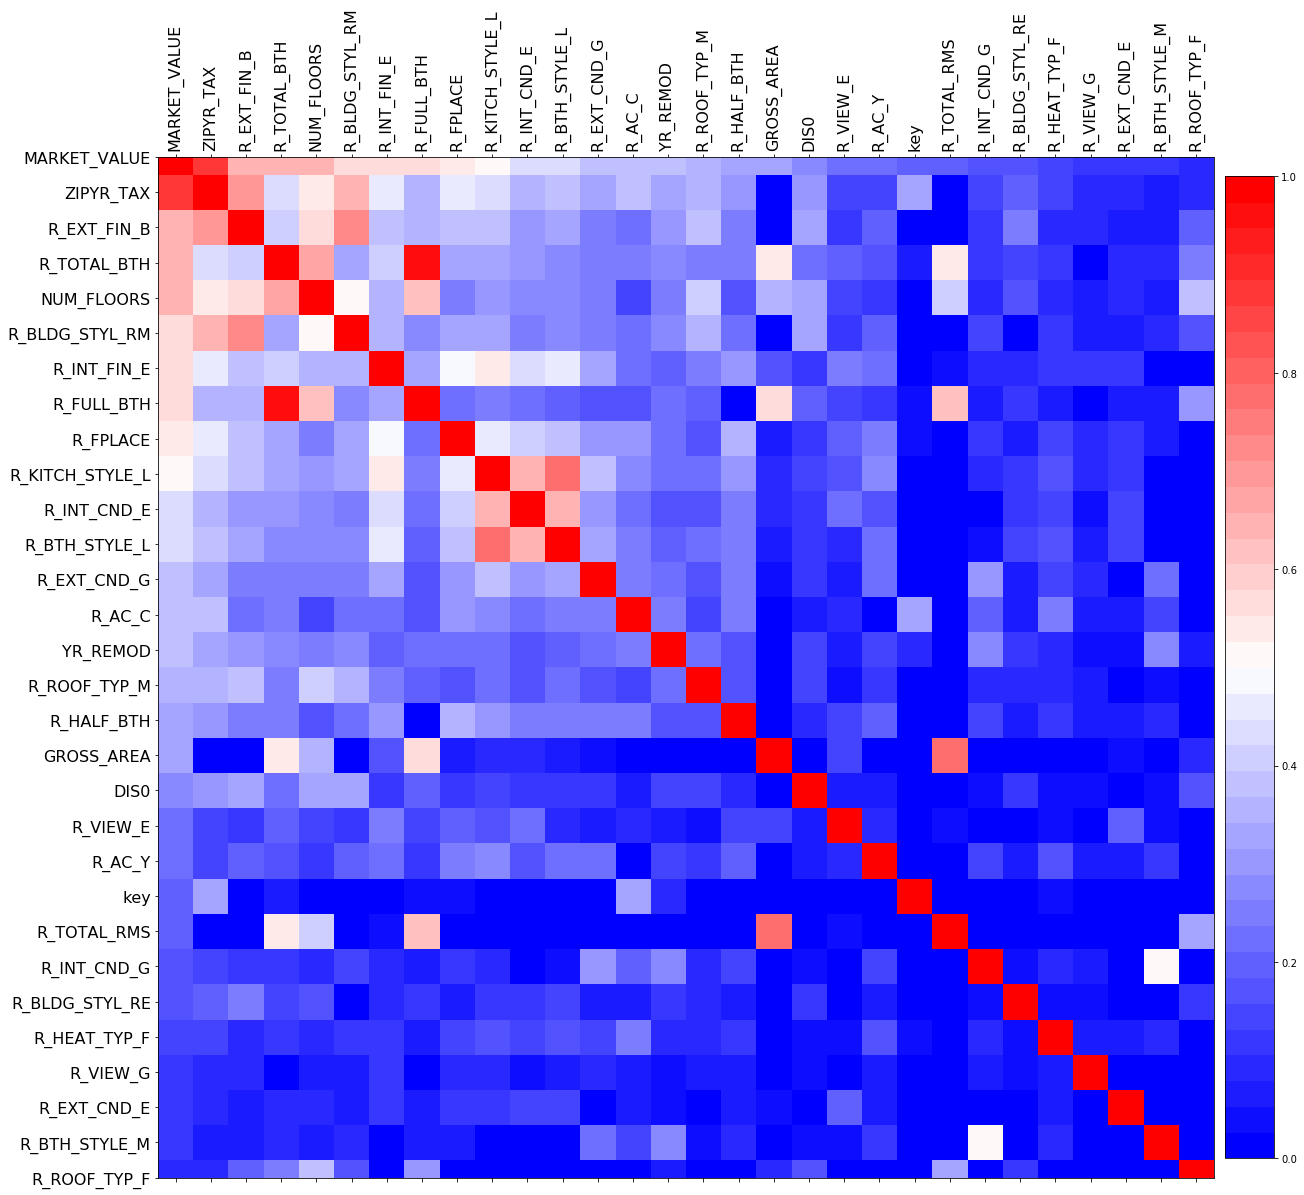

In [15]:
from matplotlib import cm as cm

corr = data.corr()
print(corr.shape);
corr = corr.sort_values(by="MARKET_VALUE",axis=0,ascending=False).sort_values(by="MARKET_VALUE",axis=1,ascending=False)

plt.figure(figsize=(20,20));
#plt.rcParams['figure.figsize'] = [20, 10]
cmap = cm.get_cmap('bwr', 38);
#plt.imshow(df.corr(), interpolation="nearest", cmap=cmap)

maxc=30 #corr.shape[0]
plt.matshow(corr.values[0:maxc,0:maxc], interpolation="nearest", cmap=cmap, fignum=1);

plt.colorbar(fraction=0.044, pad=0.01)
plt.clim(0,1)
plt.xticks(range(maxc), corr.columns[0:maxc],rotation=90,size=16);
plt.yticks(range(maxc), corr.columns[0:maxc],size=16);
plt.show()

# Data Setup for Modeling

In [16]:
test19 = data[data["key"]==2019]
train19 = data[data["key"]!=2019]

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(train19[all_features], train19[target_feature], test_size=0.2, random_state=1)

In [18]:
X_test = X_test.append(test19[all_features]);
Y_test = Y_test.append(test19[target_feature]); 

# ElasticNet 

In [19]:
from sklearn.linear_model import ElasticNetCV

In [20]:
ElasticNetCVModel2 = ElasticNetCV(l1_ratio=[1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1], 
                                  eps=0.00001, n_alphas=50, normalize=True, random_state=1,
                                  verbose=True, max_iter=1000)

In [21]:
ElasticNetCVModel2.fit(X_train,Y_train)

/home/npatel/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.........................................................................................................................................................................................................................................................................................................................................................../home/npatel/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7088644782368192, tolerance: 0.5271289074804704
  tol, rng, random, positive)
................

ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=1e-05, fit_intercept=True,
             l1_ratio=[1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1],
             max_iter=1000, n_alphas=50, n_jobs=None, normalize=True,
             positive=False, precompute='auto', random_state=1,
             selection='cyclic', tol=0.0001, verbose=True)

In [22]:
coef_val = pd.Series(ElasticNetCVModel2.coef_,all_features)
print(coef_val.sort_values(ascending=False))
#for index, feat in enumerate(X_train.columns): 
#    print(index, feat, ElasticNetCVModel2.coef_[index])

ZIPYR_TAX          0.655074
GROSS_AREA         0.394411
R_EXT_FIN_G        0.220822
R_VIEW_E           0.214259
R_INT_FIN_E        0.114405
R_BLDG_STYL_TD     0.112983
R_BLDG_STYL_CN     0.098273
R_BLDG_STYL_OT     0.094397
R_VIEW_G           0.093303
NUM_FLOORS         0.070409
R_BLDG_STYL_RR     0.064737
R_INT_CND_E        0.062812
R_BLDG_STYL_SL     0.058883
R_EXT_FIN_C        0.053863
R_EXT_FIN_V        0.045998
R_BLDG_STYL_TL     0.045764
R_AC_Y             0.041324
R_TOTAL_BTH        0.039201
R_ROOF_TYP_M       0.038896
R_EXT_FIN_W        0.026763
R_EXT_FIN_S        0.022836
R_KITCH_STYLE_M    0.020367
R_HALF_BTH         0.019382
R_INT_CND_G        0.017574
R_FULL_BTH         0.017251
R_EXT_FIN_B        0.017126
R_FPLACE           0.016797
R_BLDG_STYL_RE     0.016325
R_BLDG_STYL_RM     0.015718
R_KITCH_STYLE_L    0.015525
R_EXT_CND_G        0.014032
R_KITCH            0.014006
R_ROOF_TYP_H       0.012612
R_BLDG_STYL_RN     0.010735
R_HEAT_TYP_W       0.010294
R_VIEW_P           0

In [23]:
np.sqrt(np.dot(ElasticNetCVModel2.coef_,ElasticNetCVModel2.coef_))

0.9346961805374355

In [24]:
print("train R^2 = ", ElasticNetCVModel2.score(X_train,Y_train))
print("test R^2 = ", ElasticNetCVModel2.score(X_test,Y_test))
print("L1_ratio = ", ElasticNetCVModel2.l1_ratio_)
stdev = np.sqrt(sum((ElasticNetCVModel2.predict(X_train) - Y_train)**2) / (len(Y_train) - 2))
print(stdev, np.exp(stdev))
#print("mse = ", ElasticNetCVModel2.mse_path_)

train R^2 =  0.9248384039693408
test R^2 =  0.9244807046724782
L1_ratio =  1.0
0.17354898367933924 1.1895189523574956


plt.scatter(X_test["LIVING_AREA"],Y_test)
plt.scatter(X_test["LIVING_AREA"],ElasticNetCVModel2.predict(X_test[all_features]))

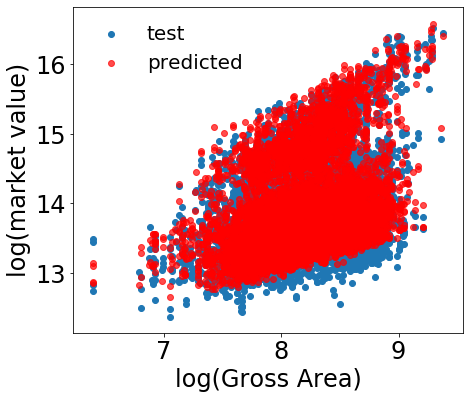

In [25]:
plt.show()
fig = plt.figure(figsize=(7,6))
plt.scatter(X_test["GROSS_AREA"],Y_test,label="test",alpha=1.0)
plt.scatter(X_test["GROSS_AREA"],ElasticNetCVModel2.predict(X_test[all_features]),color="red",label="predicted",alpha=0.7)
plt.xticks([7.0,8.0,9.0],size=24)
plt.yticks(size=24)
plt.xlabel("log(Gross Area)",size=24)
plt.ylabel("log(market value)",size=24)
plt.legend(prop={'size': 20},frameon=False)
plt.savefig("Model2_AreaVsMV.png",bbox_inches="tight",dpi=300)

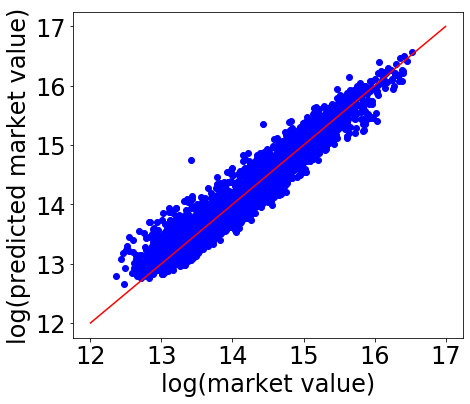

In [26]:
fig = plt.figure(figsize=(7,6))
plt.scatter(Y_test,ElasticNetCVModel2.predict(X_test[all_features]),color="blue")
plt.plot([12,17],[12,17],"-",color="red")
plt.xticks([12,13,14,15,16,17],size=24)
plt.yticks([12,13,14,15,16,17],size=24)
plt.ylabel("log(predicted market value)",size=24)
plt.xlabel("log(market value)",size=24)
#plt.legend(prop={'size': 20},frameon=False)
plt.savefig("test_predictMV.png",bbox_inches="tight",dpi=300)

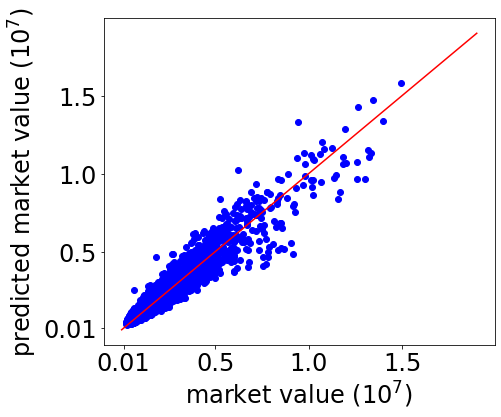

In [27]:
fig = plt.figure(figsize=(7,6))
plt.scatter(np.exp(Y_test),np.exp(ElasticNetCVModel2.predict(X_test[all_features])),color="blue")
plt.plot([0,1.9e7],[0,1.9e7],"-",color="red")
plt.xticks([0.01e7,0.50e7,1.00e7,1.5e7],["0.01","0.5","1.0","1.5"],size=24)
plt.yticks([0.01e7,0.50e7,1.00e7,1.5e7],["0.01","0.5","1.0","1.5"],size=24)
#plt.plot([12,17],[12,17],"-",color="red")
plt.ylabel("predicted market value $(10^7)$",size=24)
plt.xlabel("market value $(10^7)$",size=24)
#plt.legend(prop={'size': 20},frameon=False)
plt.savefig("test_predictMV_NOLOG.png",bbox_inches="tight",dpi=300)

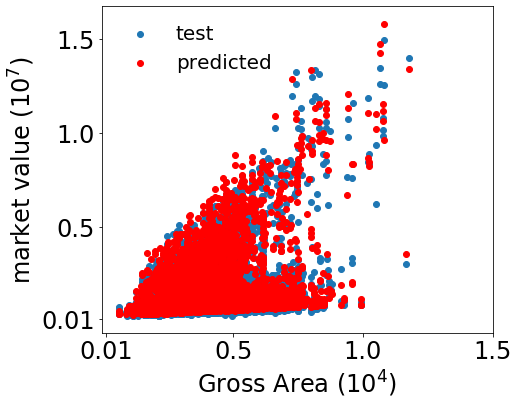

In [28]:
fig = plt.figure(figsize=(7,6))
plt.scatter(np.exp(X_test["GROSS_AREA"].values),np.exp(Y_test.values),label="test")
plt.scatter(np.exp(X_test["GROSS_AREA"].values),np.exp(ElasticNetCVModel2.predict(X_test[all_features])),color="red",label="predicted")
plt.xticks([0.01e4,0.50e4,1.00e4,1.5e4],["0.01","0.5","1.0","1.5"],size=24)
plt.yticks([0.01e7,0.50e7,1.00e7,1.5e7],["0.01","0.5","1.0","1.5"],size=24)

plt.xlabel("Gross Area $(10^4)$",size=24)
plt.ylabel("market value $(10^7)$",size=24)
plt.legend(prop={'size': 20},frameon=False)
plt.savefig("Model2_AreaVsMV_UnLog.png",bbox_inches="tight",dpi=300)

# Find out-liers and check renovation potential 

In [29]:
ndata = data.copy(deep=True); 
ndata.columns

Index(['key', 'PTYPE', 'LAND_SF', 'YR_BUILT', 'YR_REMOD', 'GROSS_AREA',
       'NUM_FLOORS', 'R_TOTAL_RMS', 'R_BDRMS', 'R_FULL_BTH', 'R_HALF_BTH',
       'R_KITCH', 'R_FPLACE', 'R_TOTAL_BTH', 'MARKET_VALUE', 'ZIPYR_TAX',
       'DIS0', 'LU_R1', 'LU_R2', 'LU_R3', 'OWN_OCC_0', 'OWN_OCC_1',
       'R_BLDG_STYL_BW', 'R_BLDG_STYL_CL', 'R_BLDG_STYL_CN', 'R_BLDG_STYL_CP',
       'R_BLDG_STYL_CV', 'R_BLDG_STYL_DK', 'R_BLDG_STYL_DX', 'R_BLDG_STYL_OT',
       'R_BLDG_STYL_RE', 'R_BLDG_STYL_RM', 'R_BLDG_STYL_RN', 'R_BLDG_STYL_RR',
       'R_BLDG_STYL_SD', 'R_BLDG_STYL_SL', 'R_BLDG_STYL_TD', 'R_BLDG_STYL_TF',
       'R_BLDG_STYL_TL', 'R_BLDG_STYL_VT', 'R_ROOF_TYP_F', 'R_ROOF_TYP_G',
       'R_ROOF_TYP_H', 'R_ROOF_TYP_L', 'R_ROOF_TYP_M', 'R_ROOF_TYP_S',
       'R_EXT_FIN_A', 'R_EXT_FIN_B', 'R_EXT_FIN_C', 'R_EXT_FIN_F',
       'R_EXT_FIN_G', 'R_EXT_FIN_M', 'R_EXT_FIN_O', 'R_EXT_FIN_P',
       'R_EXT_FIN_S', 'R_EXT_FIN_U', 'R_EXT_FIN_V', 'R_EXT_FIN_W',
       'R_BTH_STYLE_L', 'R_BTH_STYLE_M', 'R_BTH_

In [30]:
ndata["Residual"] = np.exp(ndata["MARKET_VALUE"]) - np.exp(ElasticNetCVModel2.predict(ndata[all_features]))

In [31]:
RSS = (ndata["Residual"]**2).sum()/len(ndata)

In [32]:
print("RSS =", np.sqrt(RSS), "Div = ")

RSS = 339061.83361383085 Div = 


In [33]:
print("mean of residual = ", ndata["Residual"].mean())
print("standard deviation = ", ndata["Residual"].values.std())

mean of residual =  18215.73065445481
standard deviation =  338572.16981065867


In [34]:
Y_pred = ElasticNetCVModel2.predict(X_test)

In [35]:
from sklearn import metrics
print("mean absolute error = ", metrics.mean_absolute_error(np.exp(Y_pred),np.exp(Y_test)))
print("mean squared error = ", metrics.mean_squared_error(np.exp(Y_pred),np.exp(Y_test)))
print("root mean squared error = ", np.sqrt(metrics.mean_squared_error(np.exp(Y_pred),np.exp(Y_test))))
print("mean percent error = ", np.mean(np.abs((np.exp(Y_test) - np.exp(Y_pred)) / np.exp(Y_test))) * 100)

mean absolute error =  201422.43837028008
mean squared error =  133289976906.62965
root mean squared error =  365088.9986107903
mean percent error =  13.928004630836414


In [36]:
#temper = coef_val.drop(labels = ["R_VIEW_E","R_VIEW_G","GROSS_AREA", "R_AC_Y", 
#                                 "R_BLDG_STYL_OT","R_BLDG_STYL_TD","R_BLDG_STYL_CN",
#                                 "R_BLDG_STYL_SL","R_BLDG_STYL_RE","R_BLDG_STYL_RN", 
#                                 "LU_R1","key","R_EXT_FIN_G"]) 

temper = coef_val.drop(labels = ["R_VIEW_E","R_VIEW_G","GROSS_AREA", "R_AC_Y", 
                                 "R_BLDG_STYL_OT","R_BLDG_STYL_TD","R_BLDG_STYL_CN",
                                 "R_BLDG_STYL_SL","R_BLDG_STYL_RE","R_BLDG_STYL_RN", "R_BLDG_STYL_RR", 
                                 "R_EXT_FIN_G", 
                                 "LU_R1","key"]) 

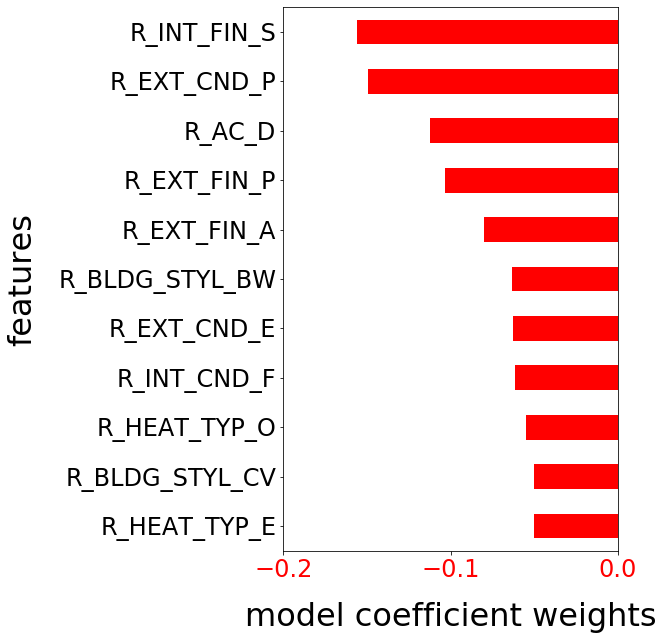

In [42]:
plt.figure(figsize=(6,10))

temper = temper.sort_values(ascending=False)
temper[temper<-0.05].plot.barh(color="red")
plt.xticks(rotation=90)

plt.yticks(size=24)
plt.xlabel("model coefficient weights",size=32,labelpad=20)
plt.ylabel("features",size=32,labelpad=20)

plt.xticks([-0.2,-0.1,0],size=24,rotation=0,color="red")
#plt.xlim(left=-0.5e6,right=0.5e6)
plt.savefig("coef_neg.png",bbox_inches="tight",dpi=300)
plt.show()


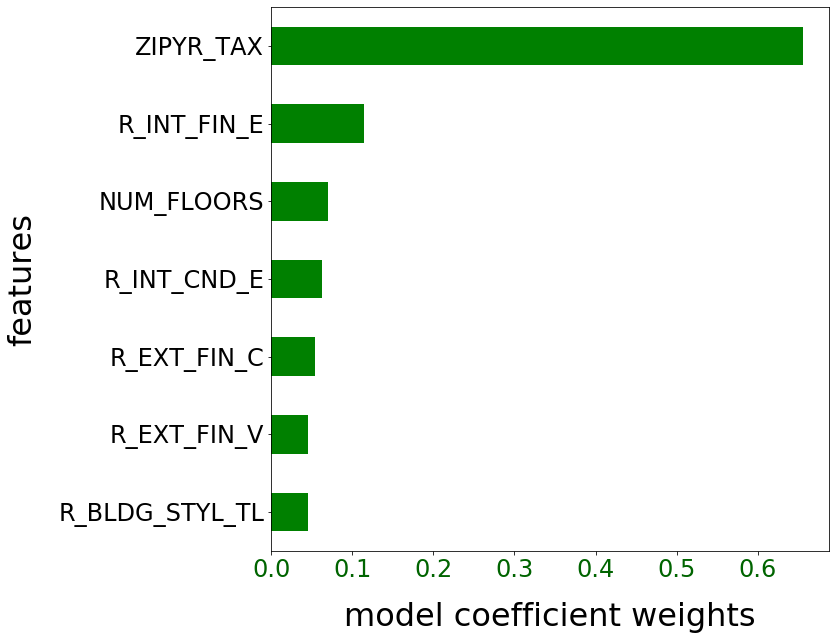

In [74]:
plt.figure(figsize=(10,10))

temper = temper.sort_values(ascending=True)
temper[temper>0.044].plot.barh(color="green")
plt.xticks(rotation=90)

plt.yticks(size=24)
plt.xlabel("model coefficient weights",size=32,labelpad=20)
plt.ylabel("features",size=32,labelpad=20)


plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6],size=24,rotation=0,color="darkgreen")
#plt.xlim(left=-0.5e6,right=0.5e6)
plt.savefig("coef_pos.png",bbox_inches="tight",dpi=300)
plt.show()

<h3> Is Error normally distributed? - assumpution of linear regression </h3>

In [51]:
my_feat = X_train.columns.ravel()

/home/npatel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


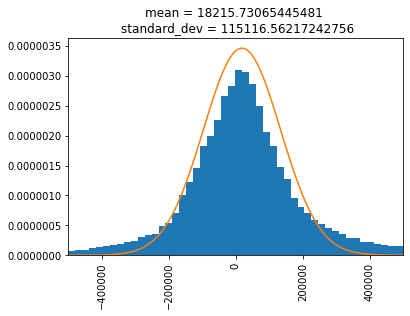

In [52]:
data["Residual"] =  -np.exp(ElasticNetCVModel2.predict(data[my_feat])) + np.exp(data["MARKET_VALUE"])
plt.hist(data["Residual"],bins=400, normed=True); 
plt.xlim(left=-0.5e6,right=0.5e6)
plt.xticks(rotation=90)

from scipy.stats import norm
xmin=-500000
xmax=500000
sigma_scale=0.34
mean=data["Residual"].mean()
std = data["Residual"].std()

x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std*sigma_scale)
plt.plot(x, y)
string = "mean = "+str(mean)+" \n standard_dev = "+str(std*sigma_scale); 
plt.title(string)
plt.show()

## Query houses for renovation
- I will try to renovate house to excellent internal condition

In [72]:
# Load the 2020 time-series data, needed to predict 2020 values!
tax_timedf = pickle.load(open("Tax_TimeSeries/2020ZipCodeTax_Predictions.dat",'rb'));
tax_timedf

,2108,2128,2129,2114,2113,2109,2111,2118,2116,2115,...,2126,2136,2122,2131,2132,2467,2134,2135,2446,2445
ds,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,...,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00
trend,15.3957,13.3241,13.8183,14.8039,13.9597,13.8644,13.4179,14.8268,14.8497,14.7348,...,12.9918,12.9543,13.2474,13.2142,13.2133,13.3063,13.7009,13.6662,13.8275,14.1796
yhat_lower,15.3899,13.3101,13.8078,14.7976,13.9515,13.8515,13.4088,14.8154,14.8392,14.7252,...,12.9793,12.9449,13.2385,13.2025,13.2039,13.2973,13.6847,13.6549,13.8128,14.164
yhat_upper,15.4013,13.3395,13.8295,14.8109,13.9696,13.8774,13.4285,14.8386,14.8584,14.7463,...,13.0071,12.9642,13.2629,13.2252,13.2229,13.3175,13.7188,13.6783,13.8413,14.1946
trend_lower,15.3897,13.3105,13.8076,14.7974,13.9515,13.8516,13.4087,14.8167,14.8392,14.725,...,12.9831,12.9449,13.2388,13.2037,13.2083,13.2966,13.6877,13.6548,13.8136,14.1651
trend_upper,15.401,13.3395,13.8296,14.8107,13.9693,13.8771,13.4286,14.8368,14.8582,14.746,...,13.0039,12.9642,13.2628,13.2236,13.2173,13.3171,13.717,13.6775,13.8397,14.1947
additive_terms,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
additive_terms_lower,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
additive_terms_upper,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
multiplicative_terms,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
data["FULLADD"] = df2["FULLADD"]
data["ZIPCODE"] = df2["ZIPCODE"]

In [62]:
recommend = data[(data["Residual"]<-100000)]
recommend = recommend[(recommend["key"]==2019) & recommend["YR_REMOD"]!=0]
recommend = recommend[recommend["R_INT_CND_E"]==0]
print(recommend["FULLADD"])

16         54 BRIMMER ST Boston, MA 2108
24          29 BRANCH ST Boston, MA 2108
32       91 MT VERNON ST Boston, MA 2108
64           7 WILLOW ST Boston, MA 2108
88        48 CHESTNUT ST Boston, MA 2108
                      ...               
30251    79.0 PARSONS ST Boston, MA 2135
30403      109 DUSTIN ST Boston, MA 2135
30451        14 MARGO RD Boston, MA 2135
30539       22.0 ELKO ST Boston, MA 2135
30778    93 WILLISTON RD Boston, MA 2445
Name: FULLADD, Length: 394, dtype: object


In [71]:
loc = 1
query = recommend.iloc[loc]
prereno_mv = np.exp(query["MARKET_VALUE"])
print("current market-value = ", prereno_mv)

query.at["R_EXT_CND_E"] = 1
query.at["R_EXT_CND_P"] = 0
postreno_mv19 =  np.exp(ElasticNetCVModel2.predict(query[my_feat].values.reshape(1,-1))[0])
print("2019 Post-Renovation Market-value: = ", postreno_mv19)

query.at["key"] = 2020
ZIPcode = query.at["ZIPCODE"]
query.at["ZIPYR_TAX"] = tax_timedf[ZIPcode]["yhat"]
postreno_mv20 =  np.exp(ElasticNetCVModel2.predict(query[my_feat].values.reshape(1,-1))[0])
print("2019 Post-Renovation Market-value: = ", postreno_mv20)
print("no-reno cost 2020 profit =", postreno_mv20 - prereno_mv)
print("no-reno cost 2020 ROI =", (postreno_mv20 - prereno_mv)/prereno_mv * 100,"%")

current market-value =  2374465.3568024905
2019 Post-Renovation Market-value: =  2636472.6431947574
2019 Post-Renovation Market-value: =  2716144.716875944
no-reno cost 2020 profit = 341679.3600734533
no-reno cost 2020 ROI = 14.389738687683638 %
